# Covid-19 Death - Data preprocessing and Data visualization    

<table>
    <tr><td><b>Name : Ridhi Sharma</b></td></tr>
    <tr><td><b>API Details : https://open.cdc.gov/apis.html"</b></td></tr>
    <tr><td><b>URL : https://data.cdc.gov/NCHS/Provisional-COVID-19-Deaths-by-Sex-and-Age/9bhg-hcku</b></td></tr>
    <tr><td><b>API endpoint :https://data.cdc.gov/resource/9bhg-hcku</b></td></tr>  
</table>      

In this assignment we will collect yearly data of deaths counts for below mention infections for ten different states of USA mentioned below.<br>
**State:**<br>
- California<br>
- Texas<br>
- Florida<br>
- New York<br>
- Pennsylvania<br>
- Illinois<br>
- Ohio<br>
- Arizona<br>
- Georgia<br>
- North Carolina<br>

**Deaths due to Infections:**<br>
- Covid<br>
- Pneumonia<br>
- Influenza<br>
- Total Deaths<br>


### This notebook covers Task 2 - Data Analysis.

We will be analysing the data based on below factors:<br>
- Years (2020,2021)
- State
- Covid-19 Deaths
- Pneumonia Deaths
- Influenza Deaths
- Different age groups
- Gender

In [1]:
#libraries used
import json
from pathlib import Path
from datetime import datetime
from datetime import date
import pandas as pd
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

The below variables stores the state names we wish to study and the colors which will be used while representing these states in plots

In [2]:
# The states that we would like to study
state_names = ["California", "Texas", "Florida", "New York", "Pennsylvania", 
              "Illinois", "Ohio", "Arizona", "Georgia", "North Carolina"]
# Colors that we will use in various plots
state_colors = {"California": "green", "Texas": "blue", "Florida": "red", "New York": "orange", "Pennsylvania": "cyan",
              "Illinois":"pink", "Ohio":"yellow", "Arizona":"grey", "Georgia":"purple", "North Carolina":"beige"}
# Default font size
fontsize = 15

The raw and the data directories:

- raw directory stores the data collected in format .json
- data directory stores clean and processed the .json files

In [3]:
# directory for raw data storage
dir_raw = Path("raw")
# directory for storing clean pre-processed data
dir_data = Path("data")
# make sure it exists
dir_data.mkdir(parents=True, exist_ok=True)

Below code is used to allign the plots in the centre of the notebook

In [4]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

For all the each state we loop through the raw directory to fetch .json files

In [5]:
state_files = {}
for state_name in state_names:
    state_files[state_name] = []
for fpath in dir_raw.iterdir():
    if fpath.suffix == ".json":
        # parse the filename
        parts = fpath.stem.split("-")
        if parts[0] in state_names:
            state_files[parts[0]].append(fpath)
for state_name in state_names:
    print("%s: Found %d raw data files" % (state_name, len(state_files[state_name])))

California: Found 1 raw data files
Texas: Found 1 raw data files
Florida: Found 1 raw data files
New York: Found 1 raw data files
Pennsylvania: Found 1 raw data files
Illinois: Found 1 raw data files
Ohio: Found 1 raw data files
Arizona: Found 1 raw data files
Georgia: Found 1 raw data files
North Carolina: Found 1 raw data files


## Parsing Data

- Now, to study the dataset we will first need to format it according to our requirement. There are few fields which are not present in each object of .json for that we need to add those fields with values as "NaN" so that it can be considered as null values which will be handled in next parts.<br>
- Also, the .json files has objects which have repeated age groups which we need to remove for correct continution of the age group.<br>
- The data set gives the time period as %Y-%m-%dT%H:%M:%S.%f which is not of our use as we are only dealing with two years 2020 and 2021, so we only need the year number in date field

In [6]:
def parse_raw_data(state_name, fpath):    
    fin = open(fpath, "r")
    jdata = fin.read()
    data = json.loads(jdata)
    rows=[]
    value = ["All Ages", "Under 1 year", "1-4 years", "5-14 years", "15-24 years", "25-34 years", "35-44 years", "45-54 years", "55-64 years"]
    for val in value:
        data[:] = [d for d in data if d.get('age_group') != val]#removes the data for the extra age groups
    data[:] = [y for y in data if y.get('start_date') != "2022-01-01T00:00:00.000"]#removes the data for the year 2022 

#--------------------------------------
    for obs in data:
        row = {"State": state_name}
        row["Year"] = datetime.strptime(obs["start_date"], "%Y-%m-%dT%H:%M:%S.%f").year
        row["Age Group"] = obs["age_group"]
        row["Sex"] = obs["sex"]
        if "total_deaths" in obs.keys():
            row["Total Deaths"] = int(obs["total_deaths"])
        else:
            row["Total Deaths"] = np.nan
        if "covid_19_deaths" in obs.keys():
            row["Covid-19 Deaths"] = int(obs["covid_19_deaths"])
        else:
            row["Covid-19 Deaths"] = np.nan
        if "pneumonia_deaths" in obs.keys():
            row["Pneumonia Deaths"] = int(obs["pneumonia_deaths"])
        else:
            row["Pneumonia Deaths"] = np.nan
        if "influenza_deaths" in obs.keys():
            row["Influenza Deaths"] = int(obs["influenza_deaths"])
        else:
            row["Influenza Deaths"] = np.nan      
        rows.append(row)
    fin.close()
    return pd.DataFrame(rows)

In [7]:
def parse_merge_raw_data(state_name, fpaths):
    df_files = []
    # process each file for this state
    print("Reading and parsing %d JSON data files ..." % len(fpaths))
    for fpath in fpaths:
        # produce a DataFrame from this file
        df_file = parse_raw_data(state_name, fpath)
        df_files.append(df_file)
    # concatenate all the DataFrames together into a single frame
    df_state = pd.concat(df_files)
    # now set the index column to be the Date, which is now unique
    df_state.set_index("State", inplace=True)
    # we will also sort the frame by its index
    return df_state.sort_index()  

Now we Parse and merge the raw data files for each state, which will give a single megred Data Frames for each state:

In [8]:
df_states= {}
for state_name in state_names:
    print("-- %s" % state_name)
    df_state = parse_merge_raw_data(state_name, state_files[state_name])
    df_states[state_name] = df_state

-- California
Reading and parsing 1 JSON data files ...
-- Texas
Reading and parsing 1 JSON data files ...
-- Florida
Reading and parsing 1 JSON data files ...
-- New York
Reading and parsing 1 JSON data files ...
-- Pennsylvania
Reading and parsing 1 JSON data files ...
-- Illinois
Reading and parsing 1 JSON data files ...
-- Ohio
Reading and parsing 1 JSON data files ...
-- Arizona
Reading and parsing 1 JSON data files ...
-- Georgia
Reading and parsing 1 JSON data files ...
-- North Carolina
Reading and parsing 1 JSON data files ...


## Data Verification
Check the format of one of the newly-created State Data Frames:

In [9]:
df_states["California"].head(8)

,Year,Age Group,Sex,Total Deaths,Covid-19 Deaths,Pneumonia Deaths,Influenza Deaths
State,,,,,,,
California,2020,0-17 years,All Sexes,3033,18.0,68,19.0
California,2020,18-29 years,All Sexes,6723,203.0,222,20.0
California,2020,30-39 years,All Sexes,8854,610.0,535,40.0
California,2020,40-49 years,All Sexes,13104,1507.0,1400,54.0
California,2020,50-64 years,All Sexes,52811,6371.0,6419,198.0
California,2020,65-74 years,All Sexes,60630,7283.0,8084,161.0
California,2020,75-84 years,All Sexes,73558,8225.0,9517,164.0
California,2020,85 years and over,All Sexes,101860,9330.0,10757,163.0


Check the number of rows and date ranges in the DataFrames:

In [10]:
def summarize_dates():
    rows = []
    for state_name in state_names:
        row = {"State": state_name}
        row["Rows"] = len(df_states[state_name])
        rows.append(row)
    return pd.DataFrame(rows).set_index("State")

# display the ranges
df_date_summary = summarize_dates()
df_date_summary

,Rows
State,
California,48
Texas,48
Florida,48
New York,48
Pennsylvania,48
Illinois,48
Ohio,48
Arizona,48
Georgia,48


Next, we check to see if we have any missing value in any of our DataFrames:

In [11]:
for state_name in state_names:
    print("-- %s" % state_name)
    missing_counts = df_states[state_name].isnull().sum()
    # which coludmns have missing values?
    missing_counts = missing_counts[missing_counts>0]
    if len(missing_counts) == 0:
        print("No missing values found")
    else:
        print(missing_counts)

-- California
Covid-19 Deaths      1
Influenza Deaths    17
dtype: int64
-- Texas
Influenza Deaths    14
dtype: int64
-- Florida
Covid-19 Deaths      3
Influenza Deaths    11
dtype: int64
-- New York
Covid-19 Deaths      5
Pneumonia Deaths     4
Influenza Deaths    21
dtype: int64
-- Pennsylvania
Covid-19 Deaths      4
Pneumonia Deaths     1
Influenza Deaths    21
dtype: int64
-- Illinois
Covid-19 Deaths      5
Pneumonia Deaths     1
Influenza Deaths    25
dtype: int64
-- Ohio
Covid-19 Deaths      3
Influenza Deaths    18
dtype: int64
-- Arizona
Covid-19 Deaths      4
Pneumonia Deaths     1
Influenza Deaths    25
dtype: int64
-- Georgia
Covid-19 Deaths      4
Pneumonia Deaths     2
Influenza Deaths    22
dtype: int64
-- North Carolina
Covid-19 Deaths      3
Pneumonia Deaths     2
Influenza Deaths    24
dtype: int64


As we have found missing values in our data-set we handle them by replacing them with median of respective columns, we are using median because there are a lot of missing values which can affect the mean of few of the rows.

In [12]:
for state_name in state_names:
    df=df_states[state_name]
    df["Total Deaths"] =  df["Total Deaths"].fillna(df["Total Deaths"].median())
    df["Covid-19 Deaths"] =  df["Covid-19 Deaths"].fillna(df["Covid-19 Deaths"].median())
    df["Pneumonia Deaths"] =  df["Pneumonia Deaths"].fillna(df["Pneumonia Deaths"].median())
    df["Influenza Deaths"] =  df["Influenza Deaths"].fillna(df["Influenza Deaths"].median())      

We check again for any missing values:

In [13]:
for state_name in state_names:
    print("-- %s" % state_name)
    missing_counts = df_states[state_name].isnull().sum()
    # which coludmns have missing values?
    missing_counts = missing_counts[missing_counts>0]
    if len(missing_counts) == 0:
        print("No missing values found")
    else:
        print(missing_counts)

-- California
No missing values found
-- Texas
No missing values found
-- Florida
No missing values found
-- New York
No missing values found
-- Pennsylvania
No missing values found
-- Illinois
No missing values found
-- Ohio
No missing values found
-- Arizona
No missing values found
-- Georgia
No missing values found
-- North Carolina
No missing values found


## Data Saving
Now, write this cleaned dataframe in .JSON format, one file per state. This will be used in further parts for analysis.

In [14]:
for state_name in state_names:
    fname = "%s.json" % state_name
    out_path = dir_data / fname
    print("Writing %s" % out_path)
    df_states[state_name].to_json(out_path, orient="records", indent=4)

Writing data\California.json
Writing data\Texas.json
Writing data\Florida.json
Writing data\New York.json
Writing data\Pennsylvania.json
Writing data\Illinois.json
Writing data\Ohio.json
Writing data\Arizona.json
Writing data\Georgia.json
Writing data\North Carolina.json


### Comparison of Total Covid-19 Deaths based on years 2020 and 2021 for each State

In [15]:
#This function computes the sum of columns based on years
def compute_sums(col_name,year):
    name = col_name+" "+str(year)
    rows = []
    for state_name in state_names:
        row = {"State": state_name}
        group_date = df_states[state_name].groupby("Year") #group the dataframe based on year
        group_sum = group_date.get_group(year) 
        row[name] = group_sum[col_name].sum()
        rows.append(row)
    return pd.DataFrame(rows).set_index("State")

In [16]:
sum_years = pd.concat([compute_sums("Covid-19 Deaths",2020), compute_sums("Covid-19 Deaths",2021)], axis=1)
sum_years

,Covid-19 Deaths 2020,Covid-19 Deaths 2021
State,,
California,69625.0,96268.0
Texas,67084.0,97328.0
Florida,49591.0,77462.0
New York,35786.0,31861.0
Pennsylvania,40586.5,42212.5
Illinois,36926.0,25822.0
Ohio,32146.0,41826.0
Arizona,21440.0,28973.0
Georgia,24161.5,35556.5


<Figure size 1008x540 with 0 Axes>

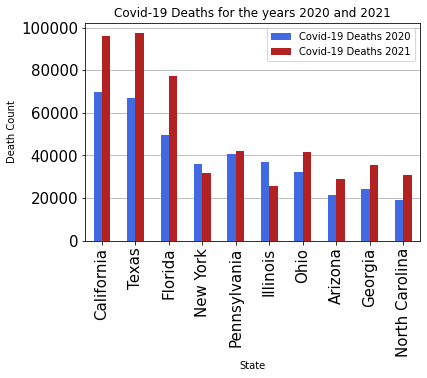

In [17]:
fig = plt.figure(figsize=(14,7.5))
ax = sum_years.plot.bar(y=['Covid-19 Deaths 2020', 'Covid-19 Deaths 2021'], 
color={ "Covid-19 Deaths 2020": "royalblue", "Covid-19 Deaths 2021": "firebrick"}, fontsize=fontsize, zorder=3)
# generate nicer x-axis labels
ticklabels = [ state_name for state_name in state_names]
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
ax.set_title("Covid-19 Deaths for the years 2020 and 2021")
ax.set_ylabel("Death Count")
ax.yaxis.grid(True);    
# fix the spacing between plots
fig.tight_layout()

From the above plot, we can see that California and Texas had the highest Covid-19 death count for the years 2020 and 2021 respectively and North Carolina and Illinois had the lowest Covid-19 death count for the years 2020 and 2021 respectively. We can also see that there is a huge difference in death counts for the cities like California, Texas and Florida for the years 2020 and 2021, while others have less difference.

In [18]:
#This function computes the sums based on different filters for different columns.
def compute_groups_sums(col_name,group_by,get_group):
    rows = []
    name=col_name+" "+get_group
    for state_name in state_names:
        row = {"State": state_name}
        df = df_states[state_name].groupby(group_by)
        group_sum = df.get_group(get_group) 
        row[name] = group_sum[col_name].sum()
        rows.append(row)
    return pd.DataFrame(rows).set_index("State")

### Comparison of Total Covid-19 deaths based male and female for each State

In [19]:
df_covid_19=pd.concat([compute_groups_sums("Covid-19 Deaths","Sex","Female"),compute_groups_sums("Covid-19 Deaths","Sex","Male"),],axis=1)

Text(0.5, 0.98, 'Comparison of Covid-19 deaths in Females and Males')

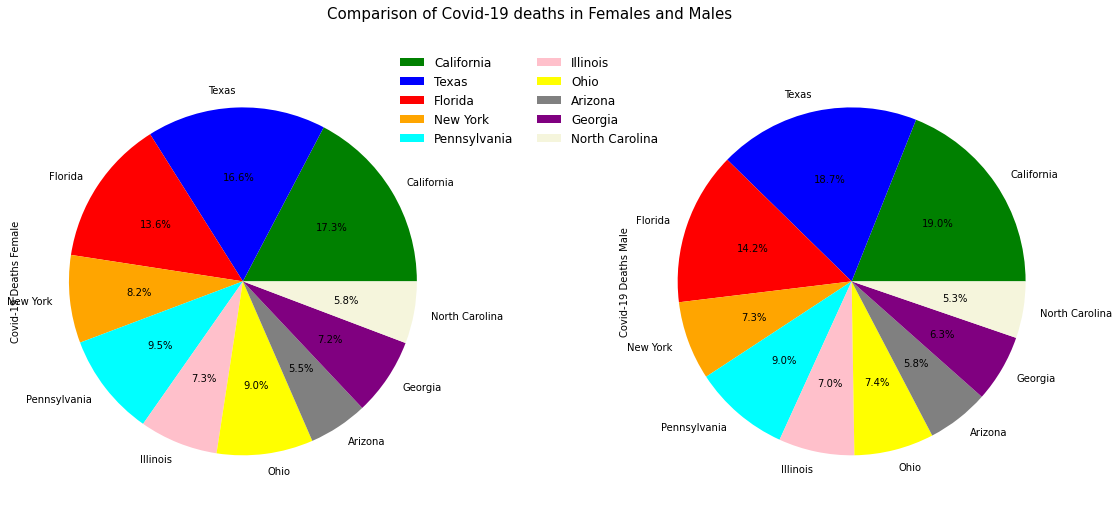

In [20]:
axes = df_covid_19.plot(kind='pie', autopct='%.1f%%', subplots=True, figsize=(20, 8),
               legend=False, labels=state_names,colors=state_colors.values())
fig = axes[0].get_figure()
legend_elements = [Patch(fc=c, label=l) for c, l in zip(state_colors.values(), state_names)]
fig.legend(handles=legend_elements, loc=9, fontsize=12, ncol=2, borderaxespad=0, bbox_to_anchor=(0., 0.8, 1, .102), 
           frameon=False)
fig.suptitle('Comparison of Covid-19 deaths in Females and Males', fontsize=15)

From the above two pie-chart we can see that California, Texas, Florida have the highest death rates for Males while, Ohio, Georgi and Pennsylvania have the highest death rates for Females. 

### Comparison of Total Covid-19 deaths based different age groups for each State

In [21]:
df_agegroups=pd.concat([compute_groups_sums("Covid-19 Deaths","Age Group","0-17 years"),
                       compute_groups_sums("Covid-19 Deaths","Age Group","18-29 years"),
                       compute_groups_sums("Covid-19 Deaths","Age Group","30-39 years"),
                       compute_groups_sums("Covid-19 Deaths","Age Group","40-49 years"),
                       compute_groups_sums("Covid-19 Deaths","Age Group","50-64 years"),
                       compute_groups_sums("Covid-19 Deaths","Age Group","65-74 years"),
                       compute_groups_sums("Covid-19 Deaths","Age Group","75-84 years"),
                       compute_groups_sums("Covid-19 Deaths","Age Group","85 years and over")],axis=1)
df_agegroups

,Covid-19 Deaths 0-17 years,Covid-19 Deaths 18-29 years,Covid-19 Deaths 30-39 years,Covid-19 Deaths 40-49 years,Covid-19 Deaths 50-64 years,Covid-19 Deaths 65-74 years,Covid-19 Deaths 75-84 years,Covid-19 Deaths 85 years and over
State,,,,,,,,
California,2651.0,1236.0,3812.0,8828.0,35586.0,36956.0,38116.0,38708.0
Texas,222.0,1674.0,4844.0,11480.0,38796.0,40476.0,37822.0,29098.0
Florida,6067.0,896.0,2506.0,5992.0,23680.0,27458.0,31706.0,28748.0
New York,5851.0,232.0,646.0,1586.0,9044.0,12394.0,16208.0,21686.0
Pennsylvania,3821.5,1501.5,754.0,1974.0,11078.0,16284.0,20400.0,26986.0
Illinois,5838.0,306.0,938.0,2076.0,9330.0,12504.0,14632.0,17124.0
Ohio,2978.0,278.0,914.0,2084.0,11176.0,15968.0,19642.0,20932.0
Arizona,3787.0,454.0,1234.0,2490.0,9722.0,11378.0,12328.0,9020.0
Georgia,4404.0,474.0,1354.0,3070.0,12534.0,13838.0,14042.0,10002.0


In [22]:
df_agegroups=df_agegroups.transpose()
df_agegroups

State,California,Texas,Florida,New York,Pennsylvania,Illinois,Ohio,Arizona,Georgia,North Carolina
Covid-19 Deaths 0-17 years,2651.0,222.0,6067.0,5851.0,3821.5,5838.0,2978.0,3787.0,4404.0,2537.0
Covid-19 Deaths 18-29 years,1236.0,1674.0,896.0,232.0,1501.5,306.0,278.0,454.0,474.0,274.0
Covid-19 Deaths 30-39 years,3812.0,4844.0,2506.0,646.0,754.0,938.0,914.0,1234.0,1354.0,880.0
Covid-19 Deaths 40-49 years,8828.0,11480.0,5992.0,1586.0,1974.0,2076.0,2084.0,2490.0,3070.0,2134.0
Covid-19 Deaths 50-64 years,35586.0,38796.0,23680.0,9044.0,11078.0,9330.0,11176.0,9722.0,12534.0,9206.0
Covid-19 Deaths 65-74 years,36956.0,40476.0,27458.0,12394.0,16284.0,12504.0,15968.0,11378.0,13838.0,11266.0
Covid-19 Deaths 75-84 years,38116.0,37822.0,31706.0,16208.0,20400.0,14632.0,19642.0,12328.0,14042.0,12334.0
Covid-19 Deaths 85 years and over,38708.0,29098.0,28748.0,21686.0,26986.0,17124.0,20932.0,9020.0,10002.0,11298.0


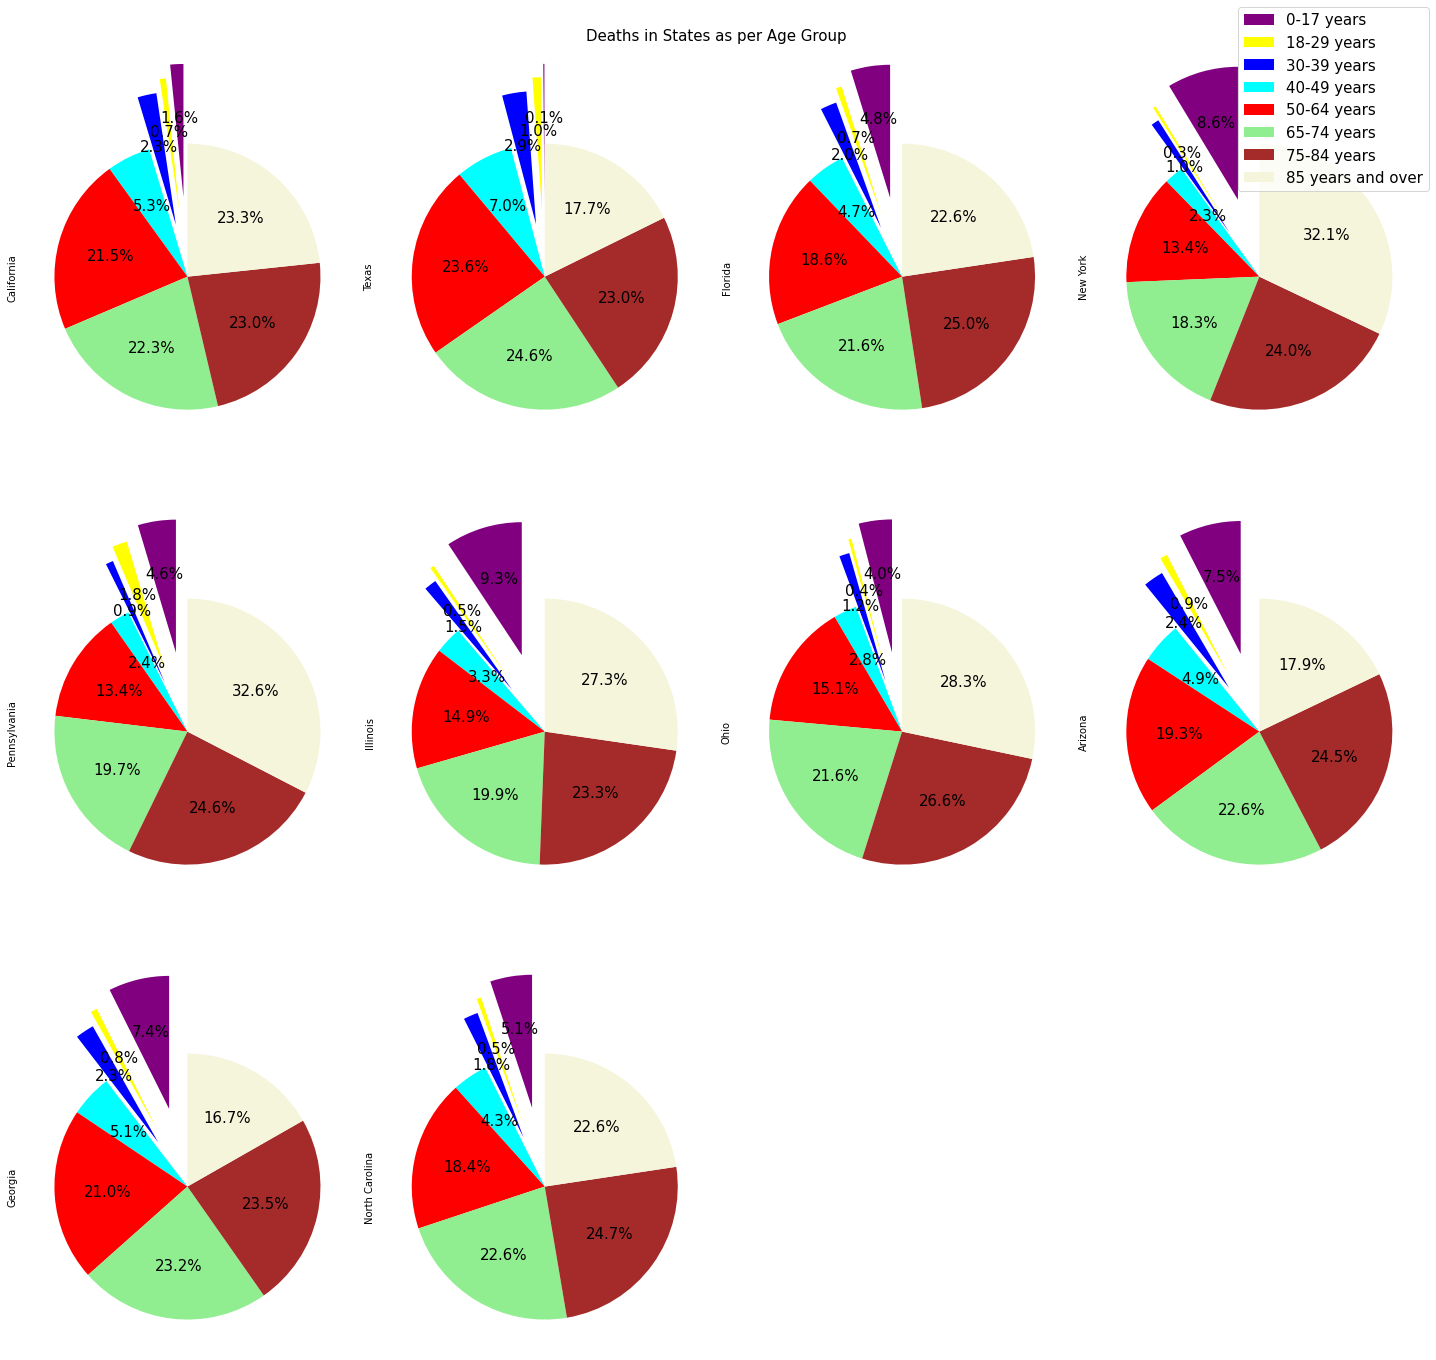

In [23]:
labels={"0-17 years":"purple","18-29 years":"yellow","30-39 years":"blue","40-49 years":"cyan",
        "50-64 years":"red","65-74 years":"lightgreen","75-84 years":"brown","85 years and over":"beige"}
explode = (0.6, 0.5, 0.4, 0.0, 0.0, 0.0,0.0,0.0)
fig = plt.figure(figsize=(20,20))
for i, state_name in enumerate(state_names):
    axc = fig.add_subplot(3, 4, i+1)
    ax = df_agegroups[state_name].plot(kind='pie',ax=axc, autopct='%.1f%%', legend=False,subplots=True, explode = explode,
                                colors=labels.values(),labels=['','','','','','','',''],
                                      fontsize=fontsize,startangle = 90) 
fig.legend(labels.keys(), fontsize=fontsize)
fig.suptitle('Deaths in States as per Age Group', fontsize=fontsize)
fig.tight_layout()

From the above pie-charts we can see that cities expect California and Illinois we can see that people below the age of 18 have higher death rates as compared to age group 18-40. While age group 75-84 had the highest death rate in most of the states.<br>
**Highest Covid-19 deaths:**<br>
-0-17 years - Illinois<br>
-18-29 years - Pennsylvania<br>
-30-39 years - Texas<br>
-40-49 years - Texas<br>
-50-64 years - Texas<br>
-65-74 years - Texas<br>
-75-84 years- Ohio<br>
-85 years and over - Pennsylvania<br>
**Lowest Covid-19 deaths:**<br>
-0-17 years - Texas<br>
-18-29 years - New York<br>
-30-39 years - Pennsylvania<br>
-40-49 years - New York<br>
-50-64 years - Pennsylvania and New York<br>
-65-74 years - New York<br>
-75-84 years - Texas and California<br>
-85 years and over - Georgia<br>

In [24]:
def compute_stats_mean(col_name):
    name="Mean"+" "+col_name
    rows = []
    for state_name in state_names:
        row = {"State": state_name}
        row[name] = df_states[state_name][col_name].mean()
        rows.append(row)
    return pd.DataFrame(rows).set_index("State")

In [25]:
df_stats_mean = pd.concat([compute_stats_mean("Covid-19 Deaths"),compute_stats_mean("Pneumonia Deaths")],axis=1)

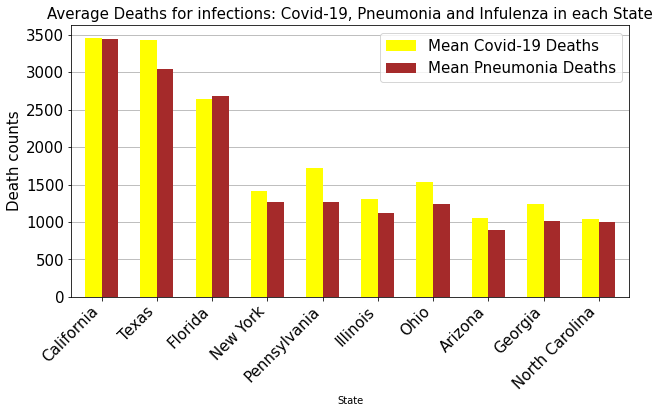

In [26]:
ax = df_stats_mean.plot.bar(figsize=(10,5), width=0.6, fontsize=fontsize, color=["yellow","brown"], zorder=2)
ax.legend(fontsize=fontsize)
ax.set_ylabel("Death counts", fontsize=fontsize)
ax.yaxis.grid(True)
ax.set_title('Average Deaths for infections: Covid-19, Pneumonia and Infulenza in each State', fontsize=fontsize)
# adjust the x-axis label rotation
plt.xticks(rotation=45, ha='right');

From the above plot, we can see that there is not much difference in death counts between Covid-19 and Pneumonia for most of the states. It can also be seen that California has the highest death count for both infections while Arizona has the least. As the Influenza had a much lesser death count it was plotted separately for clearer understanding.

In [27]:
df_stats_influenza = compute_stats_mean("Influenza Deaths")

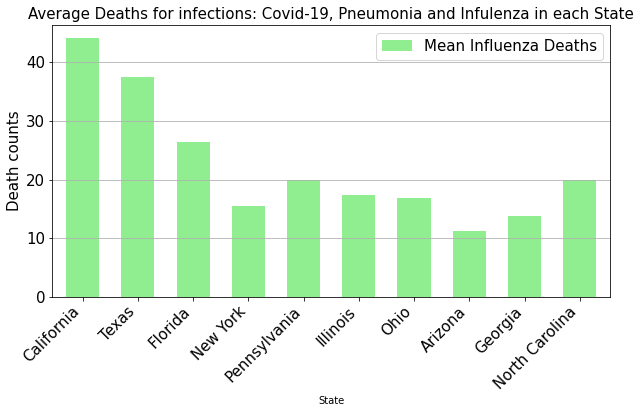

In [28]:
ax = df_stats_influenza.plot.bar(figsize=(10,5), width=0.6, fontsize=fontsize, color=["lightgreen"], zorder=1)
ax.legend(fontsize=fontsize)
ax.set_ylabel("Death counts", fontsize=fontsize)
ax.yaxis.grid(True)
ax.set_title('Average Deaths for infections: Covid-19, Pneumonia and Infulenza in each State', fontsize=fontsize)
# adjust the x-axis label rotation
plt.xticks(rotation=45, ha='right');

From the above plot, we can see that Influenza had a total count of less than 50 for all the cities while California had the highest Arizona was the lowest in the death count.

## Conclusions
In this assignment we looked at the analysis of yearly data for two years 2020 and 2021 for ten different states of the USA, The focus was mainly on COVID-19 death counts based on different factors, but Pneumonia and Influenza had were looked into based on different states. We tried to analyze the data based on different genders and age groups finding the pattern of how the infection was affected people in the USA. It was found out most people in the age group 75-84 died due to COVID and mainly males were affected. Also, we can see that the death rates increased in the year 2021 as compared to 2020 for most of the cities. We also saw Influenza had the least death rates. The most affected state with the highest death count for most of the categories was California and the least was Arizona.

The main challenge of using the free open CD API was handling a variety of fields and values, we can build up many combinations to have a clearer understanding of the infections in the USA. The data-set required a lot of pre-processing in terms of cleaning and handling missing values. Also, the data is mainly static as it only updates monthly or yearly, I focused to analyze the data yearly to figure out the trends of three different viruses in different cities.

Below points can be considered for further analysis of this data:

- As this data set had a lot of features we can analyze more facts and trends of these infections.
- The data set had a feature group by of which only year factor was used, we can use monthly data as well to find out trends based on festive and climatic seasons